### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string

In [11]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import LancasterStemmer, SnowballStemmer, RegexpStemmer, WordNetLemmatizer 

import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm

In [13]:
from afinn import Afinn

In [14]:
pd.set_option('display.max_rows',600)
pd.set_option('display.max_columns',500)

In [15]:
df = pd.read_csv('final_df_v3.csv', index_col='Unnamed: 0')

# Cleaning DF

In [16]:
df.dropna(subset=['review','rating'], inplace=True)

In [17]:
df.reset_index(drop=True, inplace=True)

In [48]:
# Too many null values in these columns
df.drop(['cuisine','recommendations'], axis=1, inplace=True)

## Removing Bad Strings

In [18]:
bad_str_1 = 'Follow NYT Food on Twitter and NYT Cooking on Instagram, Facebook, YouTube and Pinterest.'
bad_str_2 = 'Get regular updates from NYT Cooking, with recipe suggestions, cooking tips and shopping advice.'
bad_str_3 = 'What the stars mean: (None) Poor to Satisfactory * Good ** Very Good *** Excellent ****' 
bad_str_4 = 'Extraordinary Ratings reflect the reviewer\'s reaction primarily to food, with ambiance and service taken into consideration.' 
bad_str_5 = 'Menu listings and prices are subject to change.'
bad_str_6 = 'Extraordinary Ratings reflect the reviewer\'s reaction to food, ambiance and service with price taken into consideration.'
bad_str_7 = 'ON THE WEB PAST REVIEWS from the New York Times, with additional capsule reviews by Times critics: nytimes.com/dining'

def del_bad_str(review):
    
    for string in [bad_str_1, bad_str_2, bad_str_3, bad_str_4, bad_str_5, bad_str_6, bad_str_7]:
        
        if string in review:
            
            review = review.replace(string, '').strip()
    
    return review


In [19]:
df['review'] = df['review'].apply(lambda x: del_bad_str(x))

## Fixing Rating

In [20]:
def categorize(rating):
    if rating in ['0.25 star', '0.5 star', '0.75 star', 'Fair', 'Satisfactory', 'Poor', 'SATISFACTORY']:
        return '0 star'
    elif rating in ['1 star', '★']:
        return '★'
    elif rating in ['2 star','★★']:
        return '★★'
    else:
        return '★★★'

In [21]:
df['rating'] = df['rating'].apply(lambda x: categorize(x))

# Making a Stopwords List

In [32]:
NYT_stoplist = ['follow','nyt','food','twitter','cooking','instagram','facebook','youtube','pinterest',
                'recipe','suggestions','tips','shopping','advice','food', 'restaurant','atmosphere','sound','wine',
                'list','am','pm', 'daily', 'monday','tuesday','wednesday','thursday','friday','saturday','sunday',
                'hours','wheelchair','access', 'street','mr', 'dinner','dishes', 'dish', 'new', 'sauce', 'made', 'mr.', 
                'room', 'table', 'would', 'new', 'york','menu','one','two','three','ave','came', 'table', 'get', 'year',
                'water', 'go', 'along', 'first', 'second', 'restaurant', 'new', 'york', 'cooking', 'shop', 'might', 
                'also', 'make', 'made', 'food', 'menu', 'meal', 'list', 'dish', 'table', 'dining', 'server', 'room', 
                'floor','served', 'may', 'want', 'brought', 'night', 'customer', 'said', 'say', 'come', 'dinner', 'le',
                'name', 'time', 'chef', '!', 'side', 'day', 'night', 'ate', 'back', 'customers', 'restaurants',
                'ingredient', 'cook','dish', 'lunch', 'a.m.', 'p.m.''00','000','0000','0005','0008','0030','0050',
                '0082','0101','0105','0200','0220','0233','0242','0271','03','0303','0327', '0350','0404', '05', 
                '0505', '0553', '0555', '0665', '07', '0808', '0812', '0820', '0905', '0906', '0999','0003', '0012', 
                '0020', '0033', '0085', '0100', '02','0202', '0211', '0215', '0221', '0228', '0300','0400', '0412', 
                '0470', '0606', '0700', '08', '0844', '0880', '0955','★','*']

numbers_stoplist = [str(x) for x in range(0,99999)]



In [24]:
stop_entities = ['GPE', 'CARDINAL', 'PERSON', 'DATE']

def remove_named_entities(review):
    
    # Get Entities
    nlp = English()
    nlp = en_core_web_sm.load()
    
    doc = nlp(review)
    
    stop_entity_list = []
    entities=[(i, i.label_, i.label) for i in doc.ents]
    
    for entity in entities:
        
        if entity[1] in stop_entities:
            stop_entity_list.append(str(entity[0]).lower())

    return stop_entity_list

In [25]:
nested = []
for review in df['review']:
    se_list = remove_named_entities(review)
    nested.append(se_list)

In [26]:
stopped_entities = [word for sublist in nested for word in sublist]

In [27]:
stopped_entities = list(set(stopped_entities))

In [38]:
shortlist = stopwords.words('english')+ list(string.punctuation)+list(string.digits)+ NYT_stoplist + numbers_stoplist

In [39]:
shortlist = list(set(shortlist))

In [33]:
stopwords_list = stopwords.words('english')+ list(string.punctuation)+ list(string.digits)+ NYT_stoplist + numbers_stoplist +stopped_entities


In [34]:
stopwords_list = list(set(stopwords_list)) 

In [18]:
stopwords_list

['78339',
 '38246',
 '8202',
 '96800',
 '86611',
 '19666',
 '79485',
 '67016',
 '9504',
 '74072',
 '15873',
 '71556',
 'hammock',
 '21648',
 '22514',
 '20461',
 '75614',
 '23802',
 '56216',
 '21385',
 'and',
 '36968',
 '58282',
 '84905',
 'jared gadbaw',
 '74088',
 '98690',
 '50947',
 '59514',
 '70108',
 '86088',
 '87148',
 '28965',
 '34531',
 '39527',
 '79715',
 '86738',
 '1546',
 '96990',
 'only about a quarter',
 '8810',
 '88381',
 '99554',
 '76060',
 '11846',
 '49483',
 '99969',
 '56453',
 '32874',
 '39879',
 '88368',
 '56312',
 '93649',
 '89404',
 '30460',
 '89287',
 '11013',
 '21010',
 '53438',
 '2378',
 '73707',
 '40558',
 '46984',
 '10290',
 '78174',
 '92172',
 '62769',
 '82131',
 '56797',
 '40502',
 '77365',
 '89622',
 '95547',
 '8486',
 '20859',
 '61723',
 '18143',
 '5763',
 '28075',
 '32637',
 '66820',
 '81929',
 '7528',
 '77542',
 '78754',
 '28215',
 '22755',
 '52378',
 '32716',
 '36104',
 '77329',
 '45543',
 '84490',
 'eight-month-old',
 '45198',
 '13164',
 '46713',
 '6764

# More DF Cleaning

## Word/Token Counting

In [36]:
stemmer = SnowballStemmer('english')

lemmer = WordNetLemmatizer()

token = WhitespaceTokenizer()


def make_tokens(review, token):
    tokenized_review = token.tokenize(review)
    return tokenized_review

def lower(tokenized_review):
    lowercase_tokens = [token.lower() for token in tokenized_review]
    return lowercase_tokens

def remove_punc(lowercase_tokens):
    stripped_tokens = [token.translate(str.maketrans('', '', string.punctuation)) for token in lowercase_tokens]
    return stripped_tokens

def remove_stopwords(stripped_tokens, stopwords_list):
    stopped_tokens = [token for token in stripped_tokens if token not in stopwords_list]
    return stopped_tokens

def stem_tokens(stopped_tokens, stemmer):
    stems = [stemmer.stem(token) for token in stopped_tokens]
    return stems

def lem_tokens(stopped_tokens, lemmer):
    lems = [lemmer.lemmatize(token) for token in stopped_tokens]
    return lems

def normalize(review, stopword_list, lemmer, token):
    tokens = make_tokens(review, token)
    lower_tokens = lower(tokens)
    no_punc = remove_punc(lower_tokens)
    stopped = remove_stopwords(no_punc, stopword_list)
    lems = lem_tokens(stopped, lemmer)
    return lems

In [47]:
# Total Number of Tokens before lemmatizing and removing stopwords
list_tokens = [make_tokens(x,token) for x in df['review']]

tokens = [val for sublist in list_tokens for val in sublist]

len(tokens)

826102

In [42]:
df['tokens'] = df['review'].apply(lambda x: normalize(x, shortlist, lemmer, token))

In [43]:
# Number of unique words
df['vocabulary'] = df['tokens'].apply(lambda x: len(set(x)))

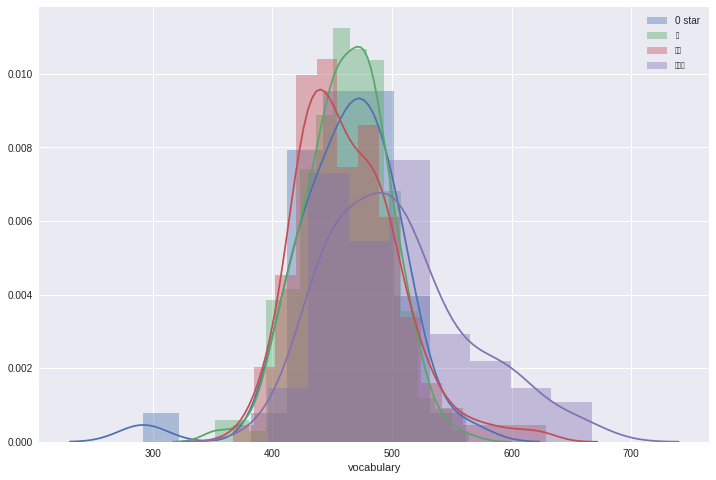

In [66]:
plt.figure(figsize=(12,8))
sns.distplot(df[df['rating']== '0 star']['vocabulary'])
sns.distplot(df[df['rating']== '★']['vocabulary'])
sns.distplot(df[df['rating']== '★★']['vocabulary'])
sns.distplot(df[df['rating']== '★★★']['vocabulary'])
plt.legend(labels=['0 star','★','★★','★★★'])

## Neighborhoods

In [64]:
top_hoods = list(df.groupby('neighborhood').count()['rating'].sort_values(ascending=False)[:19].index)

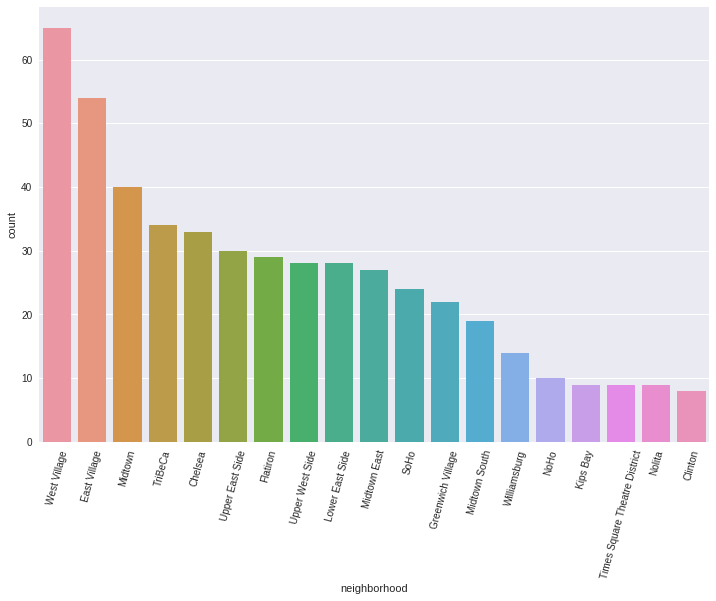

In [65]:
plt.figure(figsize=(12,8))
sns.countplot(df['neighborhood'],order = top_hoods)
plt.xticks(rotation=75);

In [50]:
# Converting "Neighborhood" to "Area" to decrease # of categories

def hood_to_area(hood):
    if hood in ['West Village', 'East Village', 'TriBeCa','SoHo', 'Lower East Side', 'Greenwich Village',
                'NoHo', 'Nolita', 'Financial District', 'Gramercy Park', 'Chinatown', 'Union Square', 
                'Battery Park City', 'Meatpacking District','NoLIta', 'Little Italy', 'Hudson Square','Fulton Ferry']:
        return 'Downtown'
    elif hood in ['Midtown', 'Midtown East', 'Midtown South', 'Times Square Theatre District', 'Kips Bay',
                  'Murray Hill', 'Koreatown', 'Hudson Yards', 'Chelsea', 'Flatiron district','Flatiron', 
                  'NoMad', 'Columbus Circle']:
        return 'Midtown'
    elif hood in ['Upper East Side', 'Upper West Side', 'Harlem']:
        return 'Uptown'
    
    elif hood in ['Williamsburg','Clinton', 'Park Slope','Greenpoint', 'Gowanus','Prospect Heights', 'Red Hook', 
                  'Carroll Gardens', 'Bushwick', 'Crown Heights', 'Cobble Hill', 'Boerum Hill', 'Fort Greene',
                  'Park Slope North', 'Columbia Street Waterfront District', 'Coney Island', 'Brooklyn Heights', 
                  'Bay Ridge','Ditmas', 'Downtown Brooklyn','Sheepshead Bay', 'Midwood']:
        
        return 'Brooklyn'
    else:
        
        return 'Other'


In [51]:
df['area'] = df['neighborhood'].apply(lambda x: hood_to_area(x))

## Reviewers

In [49]:
# Top three reviewers 
df = df[(df['reviewer'] == 'Pete Wells')|(df['reviewer'] == 'Frank Bruni')|(df['reviewer'] == 'Sam Sifton')]

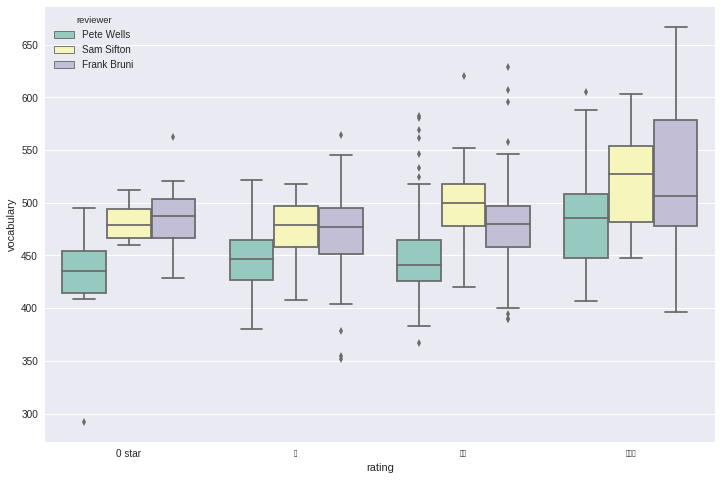

In [71]:
plt.figure(figsize=(12,8))
sns.boxplot(y=df['vocabulary'], x = df['rating'], hue=df['reviewer'], palette ='Set3', order= ['0 star','★','★★','★★★'] )


## Numerical Rating

In [52]:
# Adding a numerical rating for ML models

def add_num_rating(rating):
    
    if rating == '0 star':
        return 0
    elif rating == '★':
        return 1
    elif rating == '★★':
        return 2
    else:
        return 3
    
df['num_rating'] = df['rating'].apply(lambda x: add_num_rating(x))

In [53]:
df.head()

,name,rating,review_date,reviewer,review_url,neighborhood,review,headline,tokens,vocabulary,area,num_rating
0,Hanon,★★,2019-05-21,Pete Wells,https://www.nytimes.com/2019/05/21/dining/hano...,Williamsburg,"Hanon, a new udon shop in Williamsburg, Brookl...","Udon, Innovated for Your Pleasure","[hanon, udon, williamsburg, brooklyn, produced...",416,Brooklyn,2
1,Del Posto,★★★,2019-05-14,Pete Wells,https://www.nytimes.com/2019/05/14/dining/del-...,Chelsea,"More than a year ago, I was on the verge of re...","In Del Posto’s New Era, Cuisine and Service Ar...","[ago, verge, reviewing, del, posto, news, inte...",605,Midtown,3
2,The Freakin Rican,★,2019-05-07,Pete Wells,https://www.nytimes.com/2019/05/07/dining/the-...,Astoria,It is true that the bacalaitos at the Freakin ...,Pasteles and Two Kinds of Fried Chicken at the...,"[true, bacalaitos, freakin, rican, astoria, qu...",471,Other,1
3,Wayan,★★,2019-04-23,Pete Wells,https://www.nytimes.com/2019/04/23/dining/waya...,NoLIta,If you ate at Spice Market before it closed tw...,Tapping a Family Connection to Indonesian Food,"[spice, market, closed, year, ago, experience,...",426,Downtown,2
4,Niche,★,2019-04-16,Pete Wells,https://www.nytimes.com/2019/04/16/dining/nich...,Lower East Side,"In 2012 and 2013, when people were lining up a...",Ramen Without Broth? A Chef Doubles Down on a ...,"[people, lining, smorgasburg, houston, whole, ...",416,Downtown,1


In [54]:
df.shape

(615, 12)

In [55]:
df.describe()

,vocabulary,num_rating
count,615.000000,615.000000
mean,468.201626,1.606504
std,44.833478,0.799811
min,292.000000,0.000000
25%,438.000000,1.000000
50%,465.000000,2.000000
75%,493.000000,2.000000
max,667.000000,3.000000


# Sentiment Analysis

In [56]:
af = Afinn()

In [60]:
# Finding polarity of each sentence in a review.  Adding the average, min, max, and std polarity scores of sentences
# per article to dataframe

def af_polarity(review):
    
    polarity = []
    
    for sentence in sent_tokenize(review):
        polarity.append(af.score(sentence))
    
    avg_pol = np.mean(polarity)
    min_pol = np.min(polarity)
    max_pol = np.max(polarity)
    std_pol = np.std(polarity)
    
    return avg_pol, min_pol, max_pol, std_pol

def add_af_pol(df):
    
    df['af_avg_pol'] = df['review'].apply(lambda x: af_polarity(x)[0])
    df['af_min_pol'] = df['review'].apply(lambda x: af_polarity(x)[1])
    df['af_max_pol'] = df['review'].apply(lambda x: af_polarity(x)[2])
    df['af_std_pol'] = df['review'].apply(lambda x: af_polarity(x)[3])
    
#     df['sentiment'] = np.where(df['blob_avg_pol'] > 0.05, 1, 0)
        
    return df

df = add_af_pol(df)

In [61]:
df.head()

,name,rating,review_date,reviewer,review_url,neighborhood,review,headline,tokens,vocabulary,area,num_rating,af_avg_pol,af_min_pol,af_max_pol,af_std_pol
0,Hanon,★★,2019-05-21,Pete Wells,https://www.nytimes.com/2019/05/21/dining/hano...,Williamsburg,"Hanon, a new udon shop in Williamsburg, Brookl...","Udon, Innovated for Your Pleasure","[hanon, udon, williamsburg, brooklyn, produced...",416,Brooklyn,2,0.886364,-2.0,6.0,1.654414
1,Del Posto,★★★,2019-05-14,Pete Wells,https://www.nytimes.com/2019/05/14/dining/del-...,Chelsea,"More than a year ago, I was on the verge of re...","In Del Posto’s New Era, Cuisine and Service Ar...","[ago, verge, reviewing, del, posto, news, inte...",605,Midtown,3,0.716216,-6.0,8.0,2.016957
2,The Freakin Rican,★,2019-05-07,Pete Wells,https://www.nytimes.com/2019/05/07/dining/the-...,Astoria,It is true that the bacalaitos at the Freakin ...,Pasteles and Two Kinds of Fried Chicken at the...,"[true, bacalaitos, freakin, rican, astoria, qu...",471,Other,1,0.865385,-2.0,5.0,1.593603
3,Wayan,★★,2019-04-23,Pete Wells,https://www.nytimes.com/2019/04/23/dining/waya...,NoLIta,If you ate at Spice Market before it closed tw...,Tapping a Family Connection to Indonesian Food,"[spice, market, closed, year, ago, experience,...",426,Downtown,2,0.750000,-4.0,5.0,1.854050
4,Niche,★,2019-04-16,Pete Wells,https://www.nytimes.com/2019/04/16/dining/nich...,Lower East Side,"In 2012 and 2013, when people were lining up a...",Ramen Without Broth? A Chef Doubles Down on a ...,"[people, lining, smorgasburg, houston, whole, ...",416,Downtown,1,0.387755,-4.0,4.0,1.536180


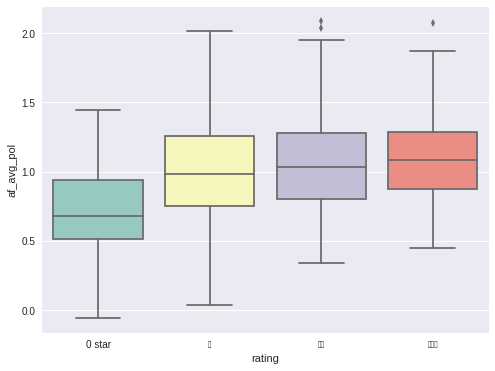

In [73]:
plt.figure(figsize=(8,6))
sns.boxplot(df['rating'], df['af_avg_pol'], palette ='Set3', order= ['0 star','★','★★','★★★'])

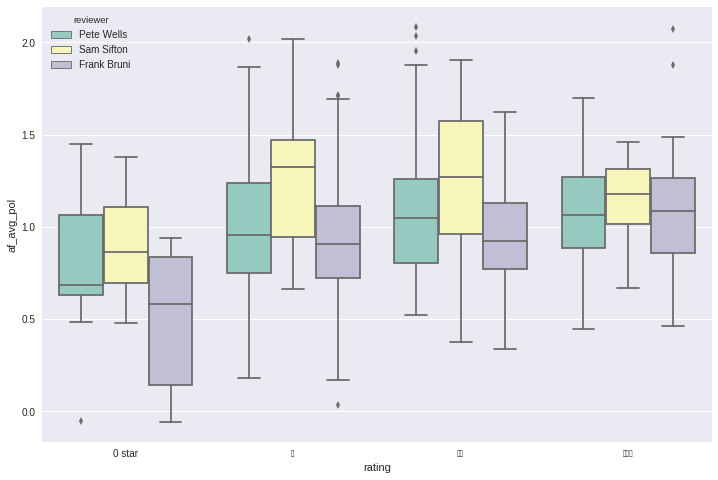

In [62]:
plt.figure(figsize=(12,8))
sns.boxplot(df['rating'], df['af_avg_pol'], palette ='Set3', order= ['0 star','★','★★','★★★'], hue=df['reviewer'])

In [63]:
df['headline_sent'] = df['headline'].apply(lambda x: af.score(x))

In [75]:
df.to_csv('df_pre_tfidf.csv')

# TF-IDF Analysis

In [76]:
tfidf_total = TfidfVectorizer(stop_words=stopwords_list)

In [77]:
tfidf_total.fit(df['review'])

/opt/conda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['00', '0776', '0898', '10downingnyc', '10th', '11th', '15eastrestaurant', '15th', '18th', '190a', '1920s', '1940s', '1990s', '2000s', '20s', '20th', '21st', '29th', '30a', '32nd', '39th', '41st', '42nd', '44th', '55th', '58th', '60s', '64th', '80th', '81st', '9th', 'aaron', 'aarón', 'ababa', 'abby', 'abdellah', 'abela', 'abraham', 'abram', 'abu', 'aby', 'accarrino', 'accepted', 'acheson', 'adam', 'adams', 'addeo', 'addis', 'adlgasser', 'adolf', 'africa', 'afrim', 'age', 'agostino', 'ahead', 'ahram', 'ai', 'aidala', 'aidan', 'ailey', 'aizpitarte', 'ajna', 'akira', 'alam', 'alana', 'albert', 'aldo', 'alessandro', 'alevras', 'alex', 'alexander', 'alexandra', 'alexandria', 'alfred', 'alicia', 'alina', 'alistair', 'allison', 'almond', 'almost', 'alphart', 'although', 'altro', 'alvarez', 'alvin', '

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words=['38153', '65283', '79956', '42139', '12514',
                            '78954', '99309', '96544', '52622', '41297',
                            '42560', '56296', '60878', '27205', '69713',
                            '16040', '51844', '54125', '61114', '79798',
                            '90705', '90815', '67903', '98995', '32554',
                            '38393', '93072', '51097', '29384', '83007', ...],
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)

In [78]:
tfidf_total_transform = tfidf_total.transform(df['review'])

In [79]:
ngrams = tfidf_total.get_feature_names()

In [80]:
ngram_polarity = [(word, af.score(word)) for word in ngrams]

In [81]:
polar_words = []
for word,score in ngram_polarity:
    if score != 0:
        polar_words.append((word, score))

In [82]:
most_polar_words = []
for word,score in polar_words:
    if score < -3 or score > 3:
        most_polar_words.append((word, score))

In [83]:
most_polar_words

[('amazing', 4.0),
 ('awesome', 4.0),
 ('bastard', -5.0),
 ('breathtaking', 5.0),
 ('brilliant', 4.0),
 ('catastrophic', -4.0),
 ('damned', -4.0),
 ('ecstatic', 4.0),
 ('exuberant', 4.0),
 ('fabulous', 4.0),
 ('fantastic', 4.0),
 ('fraud', -4.0),
 ('fun', 4.0),
 ('funnier', 4.0),
 ('funny', 4.0),
 ('godsend', 4.0),
 ('heavenly', 4.0),
 ('hell', -4.0),
 ('masterpiece', 4.0),
 ('miracle', 4.0),
 ('outstanding', 5.0),
 ('prick', -5.0),
 ('rapturous', 4.0),
 ('rejoice', 4.0),
 ('slut', -5.0),
 ('stunning', 4.0),
 ('superb', 5.0),
 ('supreme', 4.0),
 ('terrific', 4.0),
 ('terrifically', 4.0),
 ('thrilled', 5.0),
 ('torture', -4.0),
 ('tortured', -4.0),
 ('triumph', 4.0),
 ('triumphant', 4.0),
 ('win', 4.0),
 ('winning', 4.0),
 ('wins', 4.0),
 ('wonderful', 4.0),
 ('wonderfully', 4.0),
 ('wow', 4.0)]

In [88]:
tfidf_vocab = [word for word, score in most_polar_words]

In [85]:
# tfidf_vocab = list(set([lemmer.lemmatize(x) for x in tfidf_vocab]))

In [89]:
tfidf_total_df = pd.DataFrame(tfidf_total_transform.toarray(), columns = ngrams)

In [91]:
tfidf_total_df[tfidf_vocab].to_csv('tfidf-vocab')

# Creating a DF for Modeling

In [92]:
modeling = df.copy()

In [93]:
modeling.shape

(615, 17)

In [94]:
modeling.reset_index(drop=True, inplace=True)

In [95]:
modeling = pd.concat([modeling,tfidf_total_df[tfidf_vocab]], axis=1)

In [96]:
modeling.shape

(615, 58)

In [97]:
ohe_rev = OneHotEncoder(sparse=False)
ohe_area = OneHotEncoder(sparse=False)

In [98]:
reviewer_dummies = ohe_rev.fit_transform(np.array(df['reviewer']).reshape(-1,1))

In [99]:
reviewer_dum_df = pd.DataFrame(reviewer_dummies, columns = ohe_rev.get_feature_names())

In [100]:
area_dummies = ohe_area.fit_transform(np.array(df['area']).reshape(-1,1))

In [101]:
area_dum_df = pd.DataFrame(area_dummies, columns = ohe_area.get_feature_names())

In [102]:
modeling = pd.concat([modeling, reviewer_dum_df, area_dum_df], axis=1)

In [103]:
modeling.shape

(615, 66)

In [104]:
modeling.columns

Index(['name', 'rating', 'review_date', 'reviewer', 'review_url',
       'neighborhood', 'review', 'headline', 'tokens', 'vocabulary', 'area',
       'num_rating', 'af_avg_pol', 'af_min_pol', 'af_max_pol', 'af_std_pol',
       'headline_sent', 'amazing', 'awesome', 'bastard', 'breathtaking',
       'brilliant', 'catastrophic', 'damned', 'ecstatic', 'exuberant',
       'fabulous', 'fantastic', 'fraud', 'fun', 'funnier', 'funny', 'godsend',
       'heavenly', 'hell', 'masterpiece', 'miracle', 'outstanding', 'prick',
       'rapturous', 'rejoice', 'slut', 'stunning', 'superb', 'supreme',
       'terrific', 'terrifically', 'thrilled', 'torture', 'tortured',
       'triumph', 'triumphant', 'win', 'winning', 'wins', 'wonderful',
       'wonderfully', 'wow', 'x0_Frank Bruni', 'x0_Pete Wells',
       'x0_Sam Sifton', 'x0_Brooklyn', 'x0_Downtown', 'x0_Midtown', 'x0_Other',
       'x0_Uptown'],
      dtype='object')

In [105]:
modeling.to_csv('modeling_2.csv')

In [107]:
modeling.drop(['name','review_date','review_url','neighborhood','review','tokens','af_min_pol','af_max_pol'], axis=1, inplace=True)
